In [73]:
import torch, torchvision.transforms as T
from torchvision import models
from PIL import Image
import os, glob, pandas as pd, numpy as np, scipy.stats as stats, matplotlib.pyplot as plt, seaborn as sns
from torchvision.models import alexnet, AlexNet_Weights
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

## alexnet stuff

In [74]:
# load pretrainded AlexNet model
model = models.alexnet(weights=AlexNet_Weights.DEFAULT).eval()
# remove the last layer to get the feature vector
model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-1])
# transform the input image to the format expected by the model
transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def get_embeddings(img_path):
    img = transform(Image.open(img_path).convert('RGB')).unsqueeze(0)
    with torch.no_grad():
    # with torch.no_grad() is used to disable gradient calculation
        return model(img)

## get embeddings of stims used in expt

In [ ]:
# # get list of shapes used as targets
# trials_df = pd.read_csv('../input_data/trials.csv')
# shape_files_used = trials_df['target_file'].tolist()
# embeddings = [(shape_file, get_embeddings(os.path.join('../', shape_file))) for shape_file in shape_files_used]

# # convert to df
# embeddings_df = pd.DataFrame([(k, *v.squeeze().numpy()) for k, v in embeddings])
# embeddings_df.columns = ['shapes'] + [f'feature_{i}' for i in range(embeddings_df.shape[1] - 1)]

# # append associated stim & noise positions
# embeddings_df['stim_file_pos'] = trials_df['stim_file_pos']
# embeddings_df['noise_pos'] = trials_df['noise_pos']
# embeddings_df['div'] = trials_df['condition'].map({'baseline': 2, 'pen_comp': 1, 'rew_comp': 3})

# reorder_columns = ['shapes', 'div', 'stim_file_pos', 'noise_pos'] + [col for col in embeddings_df.columns if col.startswith('feature_')]
# embeddings_df = embeddings_df[reorder_columns]

# # remove features with minimal variance across shapes
# feature_cols = [col for col in embeddings_df.columns if col.startswith('feature_')]
# variances = embeddings_df[feature_cols].var()
# threshold = 0.2
# low_variance_features = variances[variances < threshold].index
# embeddings_df = embeddings_df.drop(columns=low_variance_features)

# embeddings_df.to_csv('../input_data/stimuli_embeddings.csv', index=False)

embeddings_df = pd.read_csv('../input_data/stimuli_embeddings.csv')
print(len(embeddings_df))
embeddings_df.head()


240


,shapes,div,stim_file_pos,noise_pos,feature_38,feature_45,feature_47,feature_52,feature_60,feature_88,...,feature_3978,feature_3989,feature_4029,feature_4058,feature_4062,feature_4068,feature_4072,feature_4073,feature_4076,feature_4091
0,input_data/stims/Shape_0.10_1.00.png,2,0.1,1.0,0.0,4.321363,0.265191,10.104380,6.563837,0.897169,...,1.309970,0.689861,16.736954,5.845687,1.352016,0.0,2.771213,5.519984,0.293255,0.0
1,input_data/stims/Shape_0.10_1.00.png,2,0.1,1.0,0.0,4.321363,0.265191,10.104380,6.563837,0.897169,...,1.309970,0.689861,16.736954,5.845687,1.352016,0.0,2.771213,5.519984,0.293255,0.0
2,input_data/stims/Shape_0.30_1.00.png,2,0.3,1.0,0.0,5.103432,0.098392,10.506258,6.886869,0.451986,...,0.974600,0.674793,16.914658,6.205310,1.119534,0.0,2.433510,5.862866,0.000000,0.0
3,input_data/stims/Shape_0.30_1.00.png,2,0.3,1.0,0.0,5.103432,0.098392,10.506258,6.886869,0.451986,...,0.974600,0.674793,16.914658,6.205310,1.119534,0.0,2.433510,5.862866,0.000000,0.0
4,input_data/stims/Shape_0.50_1.00.png,2,0.5,1.0,0.0,5.420555,0.012235,10.232821,7.231481,1.283351,...,1.027748,0.609162,16.070360,6.721252,0.987496,0.0,1.914770,5.642951,0.686270,0.0


## plot stim embeddings from alexnet

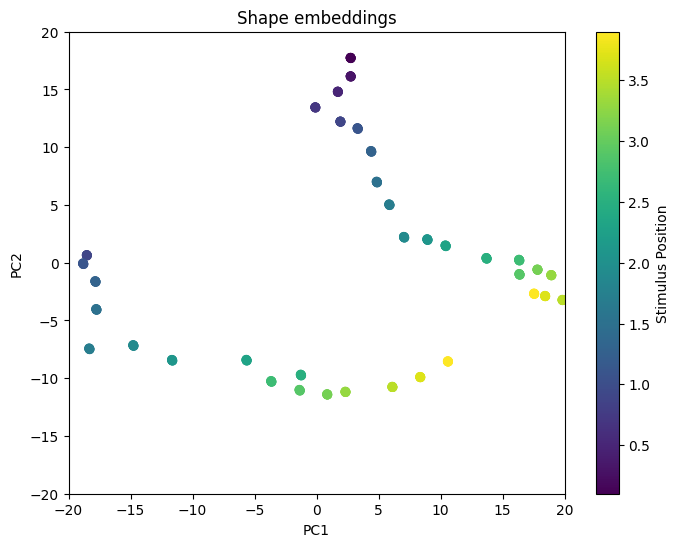

In [133]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_df.drop(columns=['shapes', 'stim_file_pos', 'noise_pos']))
reduced_embeddings_df = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])

reduced_embeddings_df['stim_file_pos'] = embeddings_df['stim_file_pos'].values
reduced_embeddings_df['noise_pos'] = embeddings_df['noise_pos'].values
reduced_embeddings_df.head()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_embeddings_df['PC1'], reduced_embeddings_df['PC2'], c=reduced_embeddings_df['stim_file_pos'])
# scatter = plt.scatter(reduced_embeddings_df['PC1'], reduced_embeddings_df['PC2'], c=reduced_embeddings_df['noise_pos'])
plt.colorbar(scatter, label='Stimulus Position')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.title('Shape embeddings')
plt.show()


## building architecture of new NN

In [77]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim

class ShapeSideNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ShapeSideNN, self).__init__()
        
        # single intermediate layer
        self.hidden = nn.Linear(input_dim, hidden_dim)
        
        # separate outputs
        self.reconstruction_output = nn.Linear(hidden_dim, output_dim)
        self.classification_output = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        
        # output for reconstruction (continuous)
        reconstruction = self.reconstruction_output(x)
        
        # output for classification (binary)
        classification = torch.sigmoid(self.classification_output(x))
        
        return reconstruction, classification

## format input data

In [134]:
# select feature cols and block (for now, divider in the middle) rows
feature_cols = [col for col in embeddings_df.columns if col.startswith('feature_')]
X = embeddings_df[feature_cols].values # shape features
X = np.column_stack((X, embeddings_df['div'].values))  # add 'div' column

y_recon = X.copy()  # reconstructed shape
y_class = (embeddings_df['stim_file_pos'] >= embeddings_df['div']).astype(int).values # shape class (0 or 1)
# y_class = (embeddings_df['stim_file_pos'] >= embeddings_df['div']).astype(int).values.reshape(-1,1) # shape class (0 or 1)

print(embeddings_df['div'].values)
print(y_class)

# converting to tensor
X = torch.tensor(X, dtype=torch.float32)
y_recon = torch.tensor(y_recon, dtype=torch.float32)
y_class = torch.tensor(y_class, dtype=torch.float32).unsqueeze(1)  # Ensure y_class is of shape (N, 1) for binary classification

print(X.shape, y_recon.shape, y_class.shape) # nrows = trials, ncols = features

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
torch.Size([240, 406]) t

## cross-validate training-testing

fold 1, fold 2, fold 3, fold 4, fold 5, 

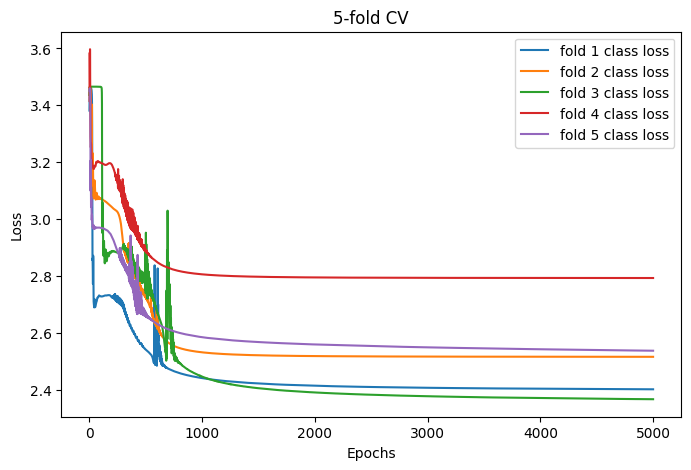

In [137]:
from sklearn.model_selection import KFold

# architecture params
input_dim, hidden_dim, output_dim = 406, 128, 406
model = ShapeSideNN(input_dim, hidden_dim, output_dim)

# loss params
recon_loss_fn, class_loss_fn = nn.MSELoss(), nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
recon_wt, class_wt = 0, 5

# convert to numpy arrays for compatibility with KFold
X, y_recon, y_class = np.array(X), np.array(y_recon), np.array(y_class)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_total_losses, fold_recon_losses, fold_class_losses = [], [], []
epochs = 5000

# CV loop
for fold, (train_id, test_id) in enumerate(kf.split(X)):

    print(f'fold {fold+1}', end=', ')

    # split into train and val
    X_train, X_test = X[train_id], X[test_id]
    y_recon_train, y_recon_test = y_recon[train_id], y_recon[test_id]
    y_class_train, y_class_test = y_class[train_id], y_class[test_id]

    # initialize model, loss, and optimizer
    model = ShapeSideNN(input_dim, hidden_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epoch_total_losses, epoch_recon_losses, epoch_class_losses = [], [], []
    # training loop
    for epoch in range(epochs):
        model.train()

        # forward pass to predict reconstruction & class
        pred_recon_train, pred_class_train = model(torch.tensor(X_train, dtype=torch.float32))
        pred_class_train = torch.sigmoid(pred_class_train)

        # calculate training losses between pred & y
        train_recon_loss = recon_loss_fn(pred_recon_train, torch.tensor(y_recon_train, dtype=torch.float32))
        train_class_loss = class_loss_fn(pred_class_train, torch.tensor(y_class_train, dtype=torch.float32))
        # weighted sum
        train_total_loss = recon_wt * train_recon_loss + class_wt * train_class_loss

        # backward pass and optimization; training
        optimizer.zero_grad()
        train_total_loss.backward()
        optimizer.step()

        # testing model
        model.eval()
        test_total_losses, test_recon_losses, test_class_losses = [], [], []
        with torch.no_grad():

            # predict left-out (test) shape & class based using trained model on left-out embeddings
            pred_recon_test, pred_class_test = model(torch.tensor(X_test, dtype=torch.float32))
            pred_class_test = torch.sigmoid(pred_class_test)

            # calculate testing losses between pred & y
            test_recon_loss = recon_loss_fn(pred_recon_test, torch.tensor(y_recon_test, dtype=torch.float32))
            test_class_loss = class_loss_fn(pred_class_test, torch.tensor(y_class_test, dtype=torch.float32))
            test_total_loss = recon_wt * test_recon_loss + class_wt * test_class_loss

        # appending epoch losses
        epoch_recon_losses.append(test_recon_loss.item())
        epoch_class_losses.append(test_class_loss.item())
        epoch_total_losses.append(test_total_loss.item())

    # appending fold losses
    fold_recon_losses.append(epoch_recon_losses)
    fold_class_losses.append(epoch_class_losses)
    fold_total_losses.append(epoch_total_losses)

# plot losses
plt.figure(figsize=(8, 5))
for i in range(5):
    plt.plot(fold_total_losses[i], label=f'fold {i+1} class loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('5-fold CV')
plt.legend()
plt.show()


### non-cross-validated training

In [108]:
# # store losses
# total_losses, recon_losses, class_losses = [], [], []

# # architecture params
# input_dim, hidden_dim, output_dim = 405, 128, 405
# model = ShapeSideNN(input_dim, hidden_dim, output_dim)

# # loss params
# recon_loss_fn, class_loss_fn = nn.MSELoss(), nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# recon_wt, class_wt = 1, 5

# # training loop
# epochs = 100
# for epoch in range(epochs):
    
#     # forward pass
#     pred_recon, pred_class = model(X)
    
#     # calculate losses
#     recon_loss = recon_loss_fn(pred_recon, y_recon)
#     class_loss = class_loss_fn(pred_class, y_class)
#     total_loss = recon_wt * recon_loss + class_wt * class_loss
    
#     # backward pass and optimization
#     optimizer.zero_grad()
#     total_loss.backward()
#     optimizer.step()

#     # store losses
#     recon_losses.append(recon_loss.item())
#     class_losses.append(class_loss.item())
#     total_losses.append(total_loss.item())

# # plot losses
# plt.figure(figsize=(8, 5))
# plt.plot(total_losses, label='Total Loss')
# plt.plot(recon_losses, label='Reconstruction Loss')
# plt.plot(class_losses, label='Classification Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training Loss Curves')
# plt.legend()
# plt.show()

## visualize hidden layer

(240, 128)


/tmp/ipykernel_817139/1371601379.py:10: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter = plt.scatter(hidden_pcs[:, 0], hidden_pcs[:, 1], c=y_class, cmap='coolwarm', edgecolor='k', alpha=0.5, marker='x')


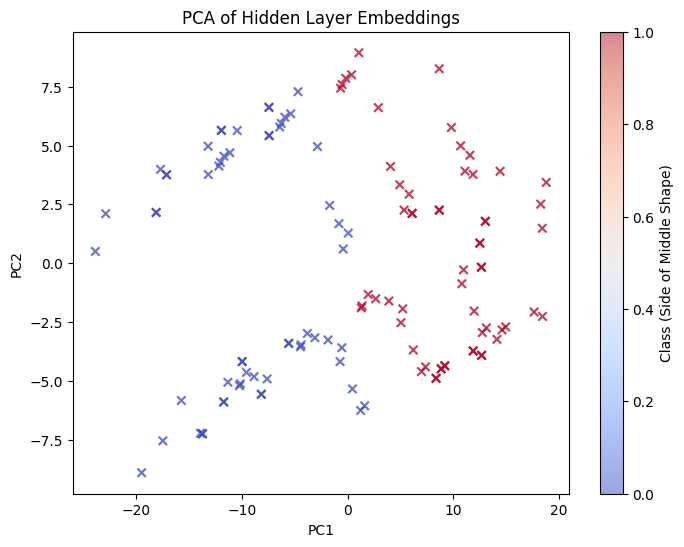

In [146]:
# Get hidden layer activations
with torch.no_grad():
    hidden_activations = model.hidden(torch.tensor(X, dtype=torch.float32)).numpy()

print(hidden_activations.shape) # (nrows, hidden_units)
pca = PCA(n_components=2)
hidden_pcs = pca.fit_transform(hidden_activations)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(hidden_pcs[:, 0], hidden_pcs[:, 1], c=y_class, cmap='coolwarm', edgecolor='k', alpha=0.5, marker='x')
# scatter = plt.scatter(hidden_pcs[:, 0], hidden_pcs[:, 1], c=embeddings_df['stim_file_pos'], cmap='coolwarm', edgecolor='k', alpha=0.5, marker='x')
# scatter = plt.scatter(hidden_pcs[:, 0], hidden_pcs[:, 1], c=embeddings_df['div'].values, cmap='coolwarm', edgecolor='k', alpha=0.5, marker='x')
plt.colorbar(scatter, label='Class (Side of Middle Shape)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Hidden Layer Embeddings')
plt.show()

In [ ]:
# 1. structural similarity instead of MSE
# 2. asymmetric classification loss
# 3. add downweighted reconstruction loss
# 4. finally, remove asymmetry and add reward